# Virtual Used Car Salesman
### by Shawn Oppermann

Predicting the pricing of used cars scattered about Craigslist

# Overview

As someone who doesn't purchase cars often, I have very little experience knowing what price any certain car should sell for. It can be very hard to tell when a deal on a user car is reasonable, of if you are selling your own car for the right price. Craigslist is one of the most popular sites for selling used cars, and provides a lot of information on posted cars. 

Thanks to Austin Reese, a Kaggle dataset with all of the data on these cars is readily available. The proposal is to train a regression model on Craigslist postings, using information such as manufacturer, model, year, etc. in order to predict the sell price for a given posting. This model can help people determine if a car they want to buy is reasonably priced, or if a car they want to sell is reasonably priced.

This problem interests me because I have not trained a regression model yet, and I consider this a good example of when to use regression. The challenge will be working with mostly categorical variables.

__Background and Research__

While this problem has been explored before, accuracy is still very low. A detailed article by Enes Gokce about traing multiple models on the same dataset can be found at towarddatascience.com (link included below). I also browsed Craigslist myself to see if there are any common or misleading features, which are explained later in this report.

[Article on Predicting Used Car Prices with Machine Learning Techniques](https://towardsdatascience.com/predicting-used-car-prices-with-machine-learning-techniques-8a9d8313952)


# Data Retrieval

__Kaggle & Craigslist__

Austin Reese uploaded this dataset on Kaggle on December 3rd, 2020. The data is scraped from Craigslist every few months. The data surprisingly does not go very far back. All of the postings were made in the year 2020.

__Details__

- The data is composed of 418213 rows and 26 columns.

I will only be focusing on 15 of these columns:
- price: the price the car goes for, our target variable as an integer
- year: the year of the car model as an integer
- manufacturer: the name of the manufacturer of the car
- model: the model name of the car
- condition: the condition of the car, ranging from brand new to salvaged
- cylinders: the number of cylinders in the car, treated as a qualitative column
- fuel: the type of fuel the car needs
- odometer: the number of miles traveled as read on the car's odometer.
- title_status: the status of the vehicle's title, often clean, lien, or missing
- transmission: manual or auto
- drive: real wheel drive or 4 wheel drive
- size: the size of the vehicle, often full-size or other
- type: the type of car; sedan, SUV, pickup, etc.
- paint_color: color of the car
- state: the state the car is being sold from

__Links__

- [Kaggle Used Cars Dataset](https://www.kaggle.com/austinreese/craigslist-carstrucks-data)

__My Context__

For my purposes, the target column will be the "price" column. Since some of the categorical variables have far too many unique values and this is supposed to be a relatively simple exersice, I will not use every relevant column. Unfortunatley, this includes the model of the car, which may severely affect the accuracy of the model.

## Python Environment/Libraries

This report uses python 2.8 with the following libraries:

- pandas for dataframe creation and manipulation
- numpy for array manipulation
- matplotlib.pyplot for creating graphs
- datetime and pytz for datetime comparisons and conversions

- category_encoders for encoding categorical data
- sklearn for cross validation, polynomial features, scaling, and regression models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pytz

import category_encoders as ce

from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics

In [2]:
import myutils

# Exploring the Data

### Raw data

Despite vehicles.csv only accounting for the year 2020, there is plenty of data, with over 400,000 rows and 26 columns. We will ignore a lot of the columns as they are either irrelevent or too hard to work with. Already, you can see NaN values in the head.

In [3]:
car_data_raw = pd.read_csv("vehicles.csv")

In [4]:
print(car_data_raw.shape)
car_data_raw.head()

(458213, 26)


,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [5]:
car_data_raw.isna().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
VIN             187549
drive           134188
size            321348
type            112738
paint_color     140843
image_url           28
description         70
state                0
lat               7448
long              7448
posting_date        28
dtype: int64

This is actually way more data than necessary, so next is choosing a resonable subset. If you look at a histogram of just the price and the odometer, it's clear that the data has some outliers, so a suitable range for the price and odometer needs to be chosen. Of note is that a lot of the prices on Craigslist are marked a 0 dollars, though if you read into the post, the seller expects money down or something similar. To try and reduce cases like this along with other outliers, a price range of 1000 to 100000 dollars was chosen, as well as an odometer max of 400000.

Histogram before subset:


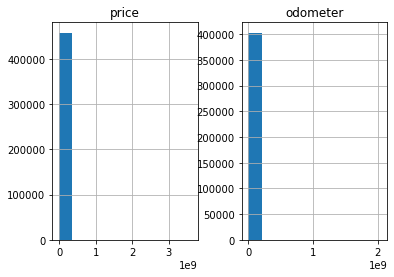

In [6]:
print("Histogram before subset:")
hist_before = car_data_raw[['price', 'odometer']].hist()

Histogram after subset:


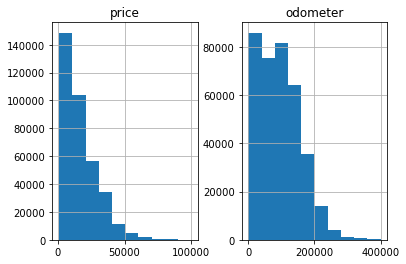

In [7]:
car_data = car_data_raw
car_data = car_data[(car_data.price >= 1000) & (car_data.price <= 100000)]
car_data = car_data[car_data.odometer <= 400000]

print("Histogram after subset:")
hist_after = car_data[['price', 'odometer']].hist()

I also restrict the dat to only columns I care about. It's possible to remove entries with NaN, but there are so many that it may remove to much important data, so I instead opt to replace NaN with the string "unknown" for categorical data and just keep NaN in the odometer column.

In [8]:
car_data_cols = ['price', 'manufacturer', 'model', 'state', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']
car_data = car_data[car_data_cols]

car_data.fillna('unknown', inplace = True)
car_data['odometer'].replace('unknown', np.nan, inplace = True)

After looking at the amount of unique values in the categorical data (which doesn't include price or odometer), It's clear the the "model" column simply has too many categories. It would be too hard to work with, so I dropped the column. This was concerning since it probably is correlated with the price.

In [9]:
car_data.nunique()
car_data = car_data.drop('model', axis = 1)
car_data_cols.remove('model')

After plotting the odometer against the price, there is a clear negative correlation, so the quantative dat is relevant.

count    362699.000000
mean      94454.212667
std       62008.125346
min           0.000000
25%       42092.000000
50%       90000.000000
75%      136000.000000
max      400000.000000
Name: odometer, dtype: float64


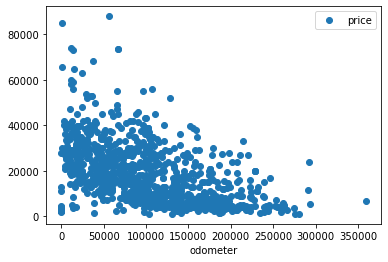

In [10]:
print(car_data.odometer.describe())
odometer_graph = car_data.head(1000).plot(x = 'odometer', y = 'price', style='o')

After looking at the mean price for categories in the categorical data, here are some observations:
- Two manufacturers have an unusually high average price.
- New and excellent cylinders indicate low prices, going against intuition.
- Rebuilt and salvaged transmissions indicate low prices.
- There are plenty of unknowns, which may negatively affect the model.

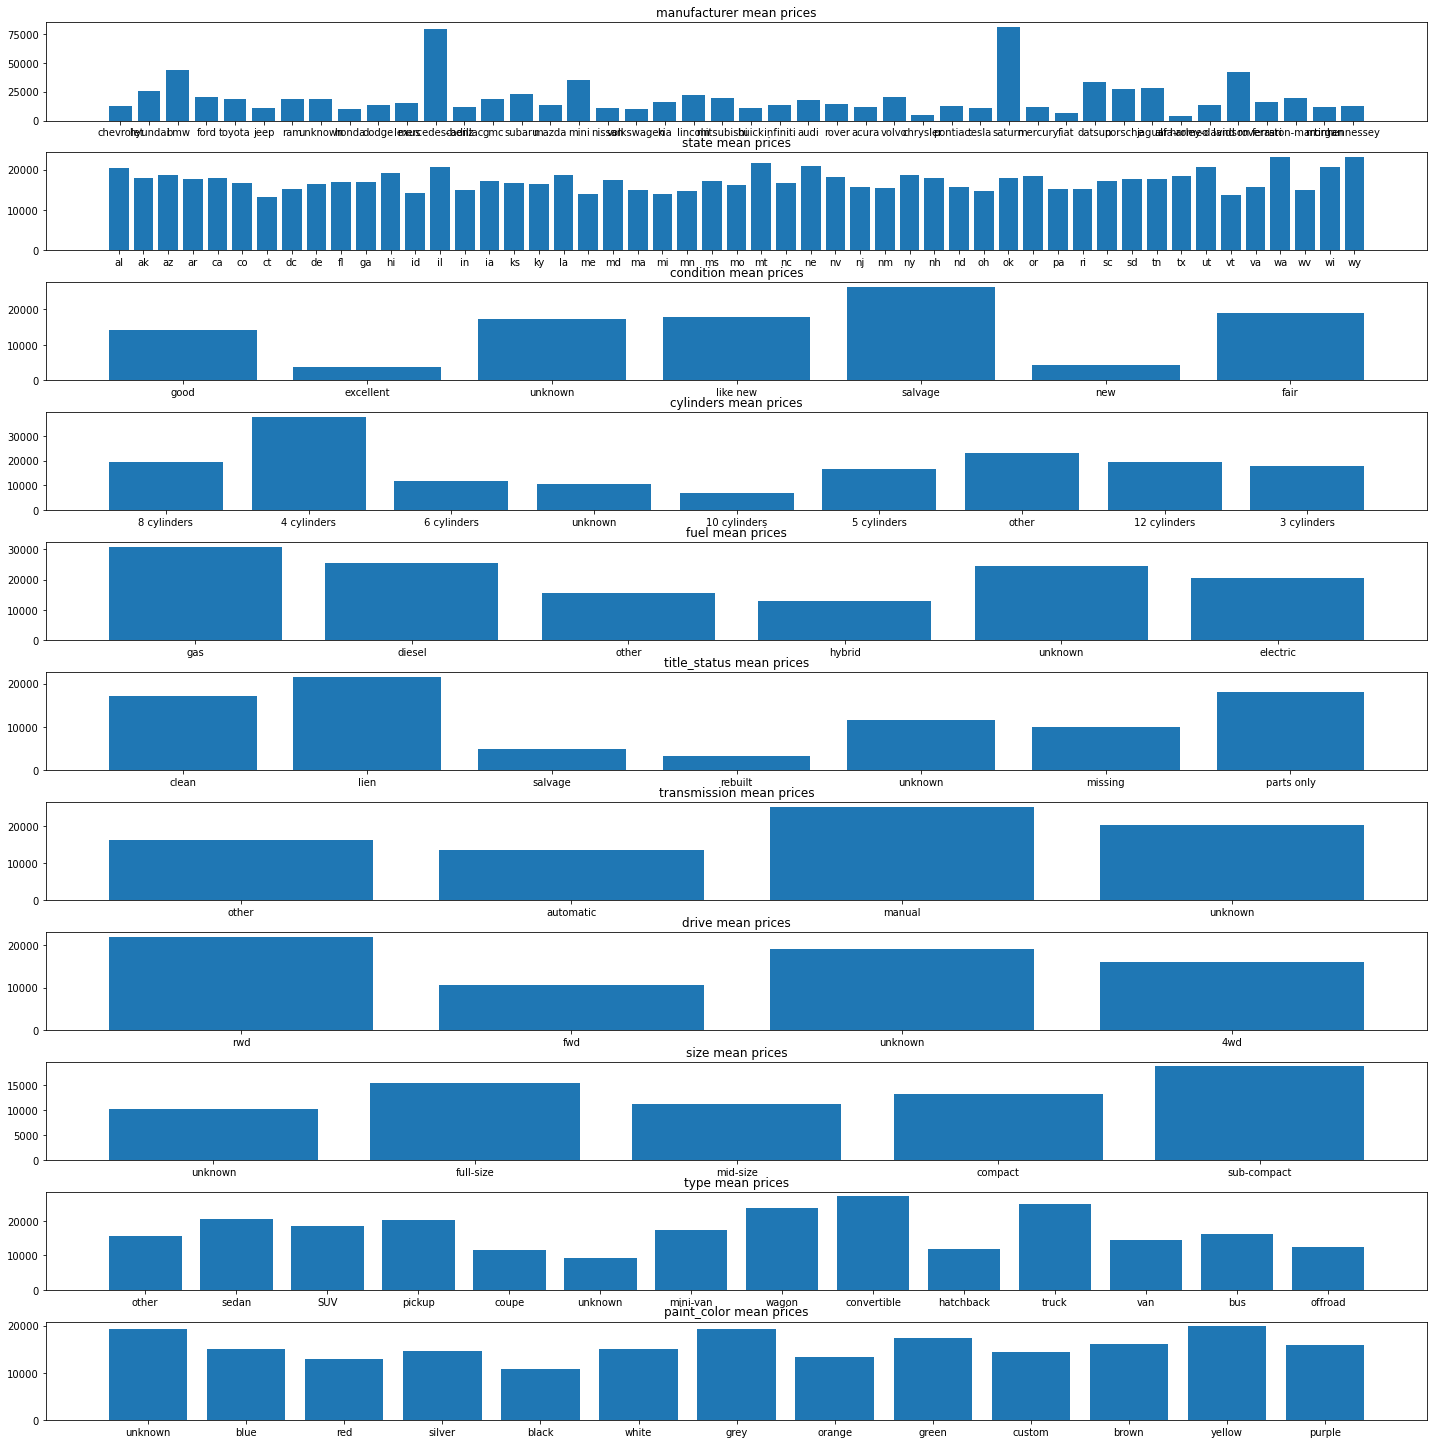

In [11]:
myutils.plot_categorical_means(car_data, car_data_cols)

# Preparing Data

The models we are using for regression are Ridge and Lasso. Before training, the data needs to be encoded. Since a lot of the data is categorical with a lot of possible categories, one hot encoding may add too many dimensions to the data, so instead, the data uses target encoding, which assigns each category a value based on the mean price for that category. The data can then be made into polynomial features, which are then scaled using standard scale.

# Modeling

- Since this is a regression problem for this report, I will focus on using two regression models, Ridge and Lasso. Ridge is best when we know that all of the features in the dataset are correlated with the target variable so that no bias is introduced when a feature doesn't actually affect the target variable. I expect Lasso to perform better because it can remove the impact of noncorrelated features, and I expect that features such as color and state don't heavilty affect the price.

- What is a good baseline?

- The metric we will be focusing on is the absolute mean error, because a person utilizing this model is really only interested in the prediction being within some margin of error, like $500.

## Fine tuning

- Ridge and Lasso both have one main hyperparameter, alpha, which reduces the variance of the predictions. I will grid search through the values .25, .5, 1, 2, and 4.

- For the polynomial features, I will use degrees 1 through 3. As a warning, one the training gets to degree 3, the training is very slow. Allow 20-30 min for the training.

- There two hyperparameters give 15 possible combinations for training, so I use a 15-fold cross validation.

In [12]:
X = car_data.drop(['price'], axis = 1)
y = car_data['price']

(Apologies in advance, run the cells below and the output should be correct.)

In [22]:
ridge_model, lasso_model, X_test, y_test = myutils.train(X, y)

alpha = 2 , p-degree = 3
    Ridge Score: 0.7618856321359114
    Lasso Score: 0.7511297922535407


TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'

In [23]:
myutils.test_accuracy(ridge_model, lasso_model, X_test, y_test)

NameError: name 'X_test' is not defined

# Results and Conclusion

Unfortnately, the resulting accuracy isn't near good enough for practical use. An average error of over 5000 dollars would be far to much for a predicted car price to be reasonable. Nobody using this model would be satisfied know that the prediction could mean you're possibly paying double the reasonable price or selling half of it. On the other hand, the error was actually on par with the article near the beginning of the report. When they trained using Ridge and Lasso, they got an absolut mean error of 5405 dollars and 5406 dollars respectively. Considering that I didn't do anything too crazy with my data, I suppose I shouldn't be too surprised I ended up with about the same results.

I believe more could have been done to reduce the error, but as it stands, I think information like the model of the car is too important to ignore. Maybe it's possible to use the 100 most common model strings and train on those alone, or do something more advanced like watch the model string with a list of known models. It's also possible that making unknown a category of its own could have been a bad idea, considering that a very good portion of the data had NaN values at the beginning.

It's hard to be very certain that this model was trained properly given the nature of the data. Using target encoding on so may values propably negatively affected the accuracy. It would also be nice if a lot of the specifications for cars on Craigslist weren't manually typed strings. That way, the number of models would probably be drastically reduced.

Given more time, I would definitely consider going back and finding a good way to use the car's model type in training.